# <font style="color:blue">LR Scheduler</font>

We know that decreasing the learning rate with epochs or after few epochs does help in convergence. In PyTorch, we use `torch.optim.lr_scheduler` class to schedule a learning rate for the optimizer. 

In this notebook, we will see how to use different learning rate scheduler. 

We will use the "Fashion MNIST" dataset, and SGD optimizer with momentum to illustrate the convergence of different learning rate schedulers.

We will use LetNet with batch norm CNN architecture.


In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt  # one of the best graphics library for python
plt.style.use('ggplot')

In [3]:
import os
import time

from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler

# <font style="color:blue">1. LeNet Architecture with BatchNorm</font>


In [4]:
class LeNetBN(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.BatchNorm2d(6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=120, out_features=84), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        x = self._body(x)
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

# <font style="color:blue">2. Display the Network</font>

In [5]:
lenetBN_model = LeNetBN()
print(lenetBN_model)

LeNetBN(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


# <font style="color:blue">3. Get Fashion MNIST Data</font>

In [6]:
def get_data(batch_size, data_root='data', num_workers=1):
    
    train_test_transforms = transforms.Compose([
        # Resize to 32X32
        transforms.Resize((32, 32)),
        # this re-scale image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean (0.2860) and divide by variance (0.3530).
        # This mean and variance is calculated on training data (verify yourself)
        transforms.Normalize((0.2860, ), (0.3530, ))
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=True, download=False, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=False, download=False, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

# <font style="color:blue">4. System Configuration</font>

In [7]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

# <font style="color:blue">5. Training Configuration</font>

In [8]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 50  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.01  # determines the speed of network's weights update
    log_interval: int = 500  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "./"  # folder to save Fashion MNIST data (default: data)
    num_workers: int = 10  # number of concurrent processes using to prepare data
    device: str = 'cuda'  # device to use for training.
    


# <font style="color:blue">6. System Setup</font>

In [9]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

# <font style="color:blue">7. Training</font>
We are familiar with the training pipeline used in PyTorch.

In [10]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

# <font style="color:blue">8. Validation</font>

In [11]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

# <font style="color:blue">9. Main</font>

In this section of code, we use the configuration parameters defined above and start the training. Here are the important actions being taken in the code below:

1. Set up system parameters like CPU/GPU, number of threads etc
1. Load the data using dataloaders
1. For each epoch, call train function, and for every test interval, call validation function.
1. Do `scheduler.step()` to update learning rate for next epoch.
1. Set up variables to track loss and accuracy and start training.



In [12]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
        
        # scheduler step/ update learning rate
        if scheduler is not None:
            if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_loss)
            else:
                scheduler.step()
        
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

# <font style="color:blue">10. Training: SGD Momentum</font>

```
torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)
```

The default value of momentum is `0`, change it to `0.9`.

Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [13]:
model = LeNetBN()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=train_config.learning_rate,
    momentum = 0.9
)


model, train_loss_sgd_momentum, train_acc_sgd_momentum, test_loss_sgd_momentum, test_acc_sgd_momentum = main(
    model, 
    optimizer)



Train Epoch: 0 [16000/60000] Loss: 0.503387 Acc: 0.8125
Train Epoch: 0 [32000/60000] Loss: 0.287460 Acc: 0.9062
Train Epoch: 0 [48000/60000] Loss: 0.345788 Acc: 0.8438
Elapsed 8.10s, 8.10 s/epoch, 0.00 s/batch, ets 397.05s

Test set: Average loss: 0.3772, Accuracy: 8623/10000 (86%)

Train Epoch: 1 [16000/60000] Loss: 0.272630 Acc: 0.8750
Train Epoch: 1 [32000/60000] Loss: 0.469388 Acc: 0.8750
Train Epoch: 1 [48000/60000] Loss: 0.236101 Acc: 0.9375
Elapsed 17.22s, 8.61 s/epoch, 0.00 s/batch, ets 413.16s

Test set: Average loss: 0.3212, Accuracy: 8846/10000 (88%)

Train Epoch: 2 [16000/60000] Loss: 0.401461 Acc: 0.8125
Train Epoch: 2 [32000/60000] Loss: 0.671169 Acc: 0.7812
Train Epoch: 2 [48000/60000] Loss: 0.380189 Acc: 0.8125
Elapsed 26.24s, 8.75 s/epoch, 0.00 s/batch, ets 411.09s

Test set: Average loss: 0.3006, Accuracy: 8942/10000 (89%)

Train Epoch: 3 [16000/60000] Loss: 0.188662 Acc: 0.9375
Train Epoch: 3 [32000/60000] Loss: 0.152142 Acc: 0.9062
Train Epoch: 3 [48000/60000] Loss:

Elapsed 266.65s, 9.19 s/epoch, 0.00 s/batch, ets 193.09s

Test set: Average loss: 0.4124, Accuracy: 9030/10000 (90%)

Train Epoch: 29 [16000/60000] Loss: 0.179784 Acc: 0.9062
Train Epoch: 29 [32000/60000] Loss: 0.061822 Acc: 0.9688
Train Epoch: 29 [48000/60000] Loss: 0.227193 Acc: 0.9375
Elapsed 276.02s, 9.20 s/epoch, 0.00 s/batch, ets 184.01s

Test set: Average loss: 0.3914, Accuracy: 9014/10000 (90%)

Train Epoch: 30 [16000/60000] Loss: 0.058862 Acc: 0.9688
Train Epoch: 30 [32000/60000] Loss: 0.200135 Acc: 0.9375
Train Epoch: 30 [48000/60000] Loss: 0.201345 Acc: 0.9375
Elapsed 285.49s, 9.21 s/epoch, 0.00 s/batch, ets 174.98s

Test set: Average loss: 0.4043, Accuracy: 9020/10000 (90%)

Train Epoch: 31 [16000/60000] Loss: 0.093131 Acc: 0.9375
Train Epoch: 31 [32000/60000] Loss: 0.013705 Acc: 1.0000
Train Epoch: 31 [48000/60000] Loss: 0.072525 Acc: 0.9688
Elapsed 295.89s, 9.25 s/epoch, 0.00 s/batch, ets 166.44s

Test set: Average loss: 0.4556, Accuracy: 9049/10000 (90%)

Train Epoch: 32

# <font style="color:blue">12. Training with Learning Rate Scheduler</font>


## <font style="color:green">12.1. Time Based (MultiplicativeLR)</font>

$$
\alpha = \frac{\alpha_0}{1 + \gamma n} 
$$

where, $\alpha_0 = \text{inital learning rate} $

$\gamma = \text{decay_rate}$

$n = \text{epoch}$

**MultiplicativeLR method in PyTorch:**

```
torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda, last_epoch=-1)
```

- `optimizer` (Optimizer) – Wrapped optimizer.

- `lr_lambda` (function or list) – A function which computes a multiplicative factor given an integer parameter epoch, or a list of such functions, one for each group in optimizer.param_groups.

- `last_epoch` (python:int) – The index of last epoch. Default: -1.

Details find [here](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.MultiplicativeLR).


In [14]:
model = LeNetBN()

init_learning_rate = 0.02

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr = init_learning_rate,
    momentum = 0.9
)

decay_rate = 0.5
lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)


model, train_loss_time_based, train_acc_time_based, test_loss_time_based, test_acc_time_based = main(
    model, 
    optimizer, 
    scheduler)



Train Epoch: 0 [16000/60000] Loss: 0.493107 Acc: 0.8438
Train Epoch: 0 [32000/60000] Loss: 0.312196 Acc: 0.8438
Train Epoch: 0 [48000/60000] Loss: 0.311132 Acc: 0.8750
Elapsed 9.85s, 9.85 s/epoch, 0.01 s/batch, ets 482.51s

Test set: Average loss: 0.3912, Accuracy: 8587/10000 (86%)

Train Epoch: 1 [16000/60000] Loss: 0.259519 Acc: 0.8750
Train Epoch: 1 [32000/60000] Loss: 0.384219 Acc: 0.8750
Train Epoch: 1 [48000/60000] Loss: 0.219995 Acc: 0.9062
Elapsed 20.88s, 10.44 s/epoch, 0.01 s/batch, ets 501.21s

Test set: Average loss: 0.3158, Accuracy: 8859/10000 (89%)

Train Epoch: 2 [16000/60000] Loss: 0.257189 Acc: 0.8750
Train Epoch: 2 [32000/60000] Loss: 0.583059 Acc: 0.7812
Train Epoch: 2 [48000/60000] Loss: 0.274677 Acc: 0.8750
Elapsed 32.10s, 10.70 s/epoch, 0.01 s/batch, ets 502.91s

Test set: Average loss: 0.3050, Accuracy: 8917/10000 (89%)

Train Epoch: 3 [16000/60000] Loss: 0.184665 Acc: 0.9688
Train Epoch: 3 [32000/60000] Loss: 0.291459 Acc: 0.9062
Train Epoch: 3 [48000/60000] Los

Train Epoch: 28 [48000/60000] Loss: 0.020062 Acc: 1.0000
Elapsed 314.84s, 10.86 s/epoch, 0.01 s/batch, ets 227.99s

Test set: Average loss: 0.3382, Accuracy: 9099/10000 (91%)

Train Epoch: 29 [16000/60000] Loss: 0.191223 Acc: 0.9375
Train Epoch: 29 [32000/60000] Loss: 0.049857 Acc: 1.0000
Train Epoch: 29 [48000/60000] Loss: 0.029006 Acc: 0.9688
Elapsed 324.64s, 10.82 s/epoch, 0.01 s/batch, ets 216.43s

Test set: Average loss: 0.3477, Accuracy: 9085/10000 (91%)

Train Epoch: 30 [16000/60000] Loss: 0.070864 Acc: 0.9688
Train Epoch: 30 [32000/60000] Loss: 0.044430 Acc: 1.0000
Train Epoch: 30 [48000/60000] Loss: 0.204638 Acc: 0.9062
Elapsed 334.53s, 10.79 s/epoch, 0.01 s/batch, ets 205.04s

Test set: Average loss: 0.3444, Accuracy: 9085/10000 (91%)

Train Epoch: 31 [16000/60000] Loss: 0.021129 Acc: 1.0000
Train Epoch: 31 [32000/60000] Loss: 0.013353 Acc: 1.0000
Train Epoch: 31 [48000/60000] Loss: 0.047056 Acc: 1.0000
Elapsed 344.38s, 10.76 s/epoch, 0.01 s/batch, ets 193.71s

Test set: Aver

## <font style="color:green">12.2. Step Decay (StepLR)</font>

$$
\alpha = \alpha_0 * \gamma^{\lfloor\frac{n}{s}\rfloor}
$$

where, $\alpha_0 = \text{inital learning rate} $

$n = \text{epoch}$

$\gamma = \text{decay_rate}$

$s = \text{step_size}$

**StepLR method:**

```
torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1)
```
- `optimizer` (Optimizer) – Wrapped optimizer.

- `step_size` (python:int) – Period of learning rate decay.

- `gamma` (python:float) – Multiplicative factor of learning rate decay. Default: `0.1`.

- `last_epoch` (python:int) – The index of last epoch. Default: `-1`.

Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR).

In [15]:
model = LeNetBN()

init_learning_rate = 0.02

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr = init_learning_rate,
    momentum = 0.9
)

step_size = 10

decay_rate = 0.5

scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=decay_rate)


model, train_loss_step_decay, train_acc_step_decay, test_loss_step_decay, test_acc_step_decay = main(
    model, 
    optimizer, 
    scheduler)

Train Epoch: 0 [16000/60000] Loss: 0.493107 Acc: 0.8438
Train Epoch: 0 [32000/60000] Loss: 0.312196 Acc: 0.8438
Train Epoch: 0 [48000/60000] Loss: 0.311132 Acc: 0.8750
Elapsed 9.79s, 9.79 s/epoch, 0.01 s/batch, ets 479.68s

Test set: Average loss: 0.3912, Accuracy: 8587/10000 (86%)

Train Epoch: 1 [16000/60000] Loss: 0.298615 Acc: 0.9062
Train Epoch: 1 [32000/60000] Loss: 0.414167 Acc: 0.8438
Train Epoch: 1 [48000/60000] Loss: 0.188927 Acc: 0.9062
Elapsed 21.00s, 10.50 s/epoch, 0.01 s/batch, ets 503.93s

Test set: Average loss: 0.3359, Accuracy: 8781/10000 (88%)

Train Epoch: 2 [16000/60000] Loss: 0.279005 Acc: 0.8750
Train Epoch: 2 [32000/60000] Loss: 0.680101 Acc: 0.7812
Train Epoch: 2 [48000/60000] Loss: 0.280338 Acc: 0.8750
Elapsed 32.19s, 10.73 s/epoch, 0.01 s/batch, ets 504.34s

Test set: Average loss: 0.3254, Accuracy: 8872/10000 (89%)

Train Epoch: 3 [16000/60000] Loss: 0.170722 Acc: 0.9688
Train Epoch: 3 [32000/60000] Loss: 0.336341 Acc: 0.8438
Train Epoch: 3 [48000/60000] Los

Train Epoch: 28 [48000/60000] Loss: 0.011632 Acc: 1.0000
Elapsed 338.17s, 11.66 s/epoch, 0.01 s/batch, ets 244.88s

Test set: Average loss: 0.4746, Accuracy: 9085/10000 (91%)

Train Epoch: 29 [16000/60000] Loss: 0.125364 Acc: 0.9375
Train Epoch: 29 [32000/60000] Loss: 0.031097 Acc: 0.9688
Train Epoch: 29 [48000/60000] Loss: 0.010905 Acc: 1.0000
Elapsed 347.64s, 11.59 s/epoch, 0.01 s/batch, ets 231.76s

Test set: Average loss: 0.5007, Accuracy: 9086/10000 (91%)

Train Epoch: 30 [16000/60000] Loss: 0.010213 Acc: 1.0000
Train Epoch: 30 [32000/60000] Loss: 0.029234 Acc: 1.0000
Train Epoch: 30 [48000/60000] Loss: 0.050404 Acc: 0.9688
Elapsed 357.11s, 11.52 s/epoch, 0.01 s/batch, ets 218.87s

Test set: Average loss: 0.5106, Accuracy: 9084/10000 (91%)

Train Epoch: 31 [16000/60000] Loss: 0.014799 Acc: 1.0000
Train Epoch: 31 [32000/60000] Loss: 0.000497 Acc: 1.0000
Train Epoch: 31 [48000/60000] Loss: 0.003239 Acc: 1.0000
Elapsed 366.59s, 11.46 s/epoch, 0.01 s/batch, ets 206.21s

Test set: Aver

## <font style="color:green">12.3. Exponential Decay (ExponentialLR)</font>

$$
\alpha = \alpha_0 * \gamma^n
$$

where, $\alpha_0 = \text{inital learning rate} $

$n = \text{epoch}$

$\gamma = \text{decay_rate}$

**ExponentialLR method:**

```
torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)
```
- `optimizer` (Optimizer) – Wrapped optimizer.

- `gamma` (python:float) – Multiplicative factor of learning rate decay.

- `last_epoch` (python:int) – The index of last epoch. Default: -1.

Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ExponentialLR).

In [16]:
model = LeNetBN()

init_learning_rate = 0.02

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr = init_learning_rate,
    momentum = 0.9
)


decay_rate = 0.9

scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)


model, train_loss_exp_decay, train_acc_exp_decay, test_loss_exp_decay, test_acc_exp_decay = main(
    model, 
    optimizer, 
    scheduler)

Train Epoch: 0 [16000/60000] Loss: 0.493107 Acc: 0.8438
Train Epoch: 0 [32000/60000] Loss: 0.312196 Acc: 0.8438
Train Epoch: 0 [48000/60000] Loss: 0.311132 Acc: 0.8750
Elapsed 8.19s, 8.19 s/epoch, 0.00 s/batch, ets 401.47s

Test set: Average loss: 0.3912, Accuracy: 8587/10000 (86%)

Train Epoch: 1 [16000/60000] Loss: 0.235995 Acc: 0.9375
Train Epoch: 1 [32000/60000] Loss: 0.405274 Acc: 0.9062
Train Epoch: 1 [48000/60000] Loss: 0.214125 Acc: 0.9062
Elapsed 17.71s, 8.86 s/epoch, 0.00 s/batch, ets 425.04s

Test set: Average loss: 0.3219, Accuracy: 8823/10000 (88%)

Train Epoch: 2 [16000/60000] Loss: 0.304655 Acc: 0.8438
Train Epoch: 2 [32000/60000] Loss: 0.604872 Acc: 0.8125
Train Epoch: 2 [48000/60000] Loss: 0.327578 Acc: 0.8438
Elapsed 27.20s, 9.07 s/epoch, 0.00 s/batch, ets 426.16s

Test set: Average loss: 0.3083, Accuracy: 8893/10000 (89%)

Train Epoch: 3 [16000/60000] Loss: 0.187968 Acc: 0.9375
Train Epoch: 3 [32000/60000] Loss: 0.359738 Acc: 0.8750
Train Epoch: 3 [48000/60000] Loss:

Elapsed 273.20s, 9.42 s/epoch, 0.01 s/batch, ets 197.83s

Test set: Average loss: 0.3950, Accuracy: 9086/10000 (91%)

Train Epoch: 29 [16000/60000] Loss: 0.042911 Acc: 0.9688
Train Epoch: 29 [32000/60000] Loss: 0.015185 Acc: 1.0000
Train Epoch: 29 [48000/60000] Loss: 0.019758 Acc: 1.0000
Elapsed 283.43s, 9.45 s/epoch, 0.01 s/batch, ets 188.95s

Test set: Average loss: 0.4003, Accuracy: 9127/10000 (91%)

Train Epoch: 30 [16000/60000] Loss: 0.025417 Acc: 1.0000
Train Epoch: 30 [32000/60000] Loss: 0.042689 Acc: 1.0000
Train Epoch: 30 [48000/60000] Loss: 0.103946 Acc: 0.9375
Elapsed 292.96s, 9.45 s/epoch, 0.01 s/batch, ets 179.56s

Test set: Average loss: 0.4004, Accuracy: 9083/10000 (91%)

Train Epoch: 31 [16000/60000] Loss: 0.008913 Acc: 1.0000
Train Epoch: 31 [32000/60000] Loss: 0.012493 Acc: 1.0000
Train Epoch: 31 [48000/60000] Loss: 0.023053 Acc: 1.0000
Elapsed 302.52s, 9.45 s/epoch, 0.01 s/batch, ets 170.17s

Test set: Average loss: 0.4045, Accuracy: 9076/10000 (91%)

Train Epoch: 32

## <font style="color:green">12.4. ReduceLROnPlateau</font>

**Why do we want LR (learning rate) scheduler?**

We want LR-Scheduler so that we can decrease the learning rate when the model stopped improving, but when to decrease.  In all the above LR-schedulers, reducing strategy is already defined. So it is a matter of experiments to get the right hyperparameters of LR-scheduler. `ReduceLROnPlateeau` does solve this problem.

For the given number of epochs, if the model does not improve, it reduces the learning rate. 

**ReduceLROnPlateau method:**

```
torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
```
- `optimizer` (Optimizer) – Wrapped optimizer.

- `mode` (str) – One of min, max. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; in max mode it will be reduced when the quantity monitored has stopped increasing. Default: ‘min’.

- `factor` (python:float) – Factor by which the learning rate will be reduced. `new_lr = lr * factor`. Default: `0.1`.

- `patience` (python:int) – Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then. Default: `10`.

- `verbose` (bool) – If True, prints a message to stdout for each update. Default: False.

- `threshold` (python:float) – Threshold for measuring the new optimum, to only focus on significant changes. Default: `1e-4`.

- `threshold_mode` (str) – One of rel, abs. In rel mode, dynamic_threshold = best * ( 1 + threshold ) in ‘max’ mode or best * ( 1 - threshold ) in min mode. In abs mode, dynamic_threshold = best + threshold in max mode or best - threshold in min mode. Default: ‘rel’.

- `cooldown` (python:int) – Number of epochs to wait before resuming normal operation after lr has been reduced. Default: `0`.

- `min_lr` (python:float or list) – A scalar or a list of scalars. A lower bound on the learning rate of all param groups or each group respectively. Default: `0`.

- `eps` (python:float) – Minimal decay applied to lr. If the difference between new and old lr is smaller than eps, the update is ignored. Default: 1e-8.

Find details [here](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau)


In [17]:
model = LeNetBN()

train_config = TrainingConfiguration()

# optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=train_config.learning_rate,
    momentum = 0.9
)

factor = 0.5  # reduce by factor 0.5
patience = 5  # epochs
verbose = True

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience, verbose=verbose)


model, train_loss_plateau, train_acc_plateau, test_loss_plateau, test_acc_plateau = main(
    model, 
    optimizer, 
    scheduler)

Train Epoch: 0 [16000/60000] Loss: 0.494858 Acc: 0.8125
Train Epoch: 0 [32000/60000] Loss: 0.261072 Acc: 0.8750
Train Epoch: 0 [48000/60000] Loss: 0.334661 Acc: 0.8750
Elapsed 8.35s, 8.35 s/epoch, 0.00 s/batch, ets 408.98s

Test set: Average loss: 0.3735, Accuracy: 8643/10000 (86%)

Train Epoch: 1 [16000/60000] Loss: 0.220575 Acc: 0.9688
Train Epoch: 1 [32000/60000] Loss: 0.365529 Acc: 0.8750
Train Epoch: 1 [48000/60000] Loss: 0.221897 Acc: 0.9375
Elapsed 17.73s, 8.86 s/epoch, 0.00 s/batch, ets 425.51s

Test set: Average loss: 0.3202, Accuracy: 8825/10000 (88%)

Train Epoch: 2 [16000/60000] Loss: 0.289806 Acc: 0.8438
Train Epoch: 2 [32000/60000] Loss: 0.688733 Acc: 0.7812
Train Epoch: 2 [48000/60000] Loss: 0.317980 Acc: 0.8750
Elapsed 27.15s, 9.05 s/epoch, 0.00 s/batch, ets 425.43s

Test set: Average loss: 0.3095, Accuracy: 8883/10000 (89%)

Train Epoch: 3 [16000/60000] Loss: 0.134292 Acc: 0.9688
Train Epoch: 3 [32000/60000] Loss: 0.271700 Acc: 0.9062
Train Epoch: 3 [48000/60000] Loss:

Elapsed 273.56s, 9.43 s/epoch, 0.01 s/batch, ets 198.10s

Test set: Average loss: 0.3997, Accuracy: 9055/10000 (91%)

Train Epoch: 29 [16000/60000] Loss: 0.056993 Acc: 0.9688
Train Epoch: 29 [32000/60000] Loss: 0.050627 Acc: 1.0000
Train Epoch: 29 [48000/60000] Loss: 0.011540 Acc: 1.0000
Elapsed 282.94s, 9.43 s/epoch, 0.01 s/batch, ets 188.63s

Test set: Average loss: 0.4148, Accuracy: 9013/10000 (90%)

Train Epoch: 30 [16000/60000] Loss: 0.039378 Acc: 1.0000
Train Epoch: 30 [32000/60000] Loss: 0.137639 Acc: 0.9688
Train Epoch: 30 [48000/60000] Loss: 0.155474 Acc: 0.9375
Elapsed 292.49s, 9.44 s/epoch, 0.01 s/batch, ets 179.27s

Test set: Average loss: 0.4077, Accuracy: 9044/10000 (90%)

Train Epoch: 31 [16000/60000] Loss: 0.065780 Acc: 0.9688
Train Epoch: 31 [32000/60000] Loss: 0.024158 Acc: 1.0000
Train Epoch: 31 [48000/60000] Loss: 0.340769 Acc: 0.9375
Elapsed 301.94s, 9.44 s/epoch, 0.01 s/batch, ets 169.84s

Test set: Average loss: 0.4506, Accuracy: 9046/10000 (90%)

Train Epoch: 32

# <font style="color:blue">13. Loss Plot</font>

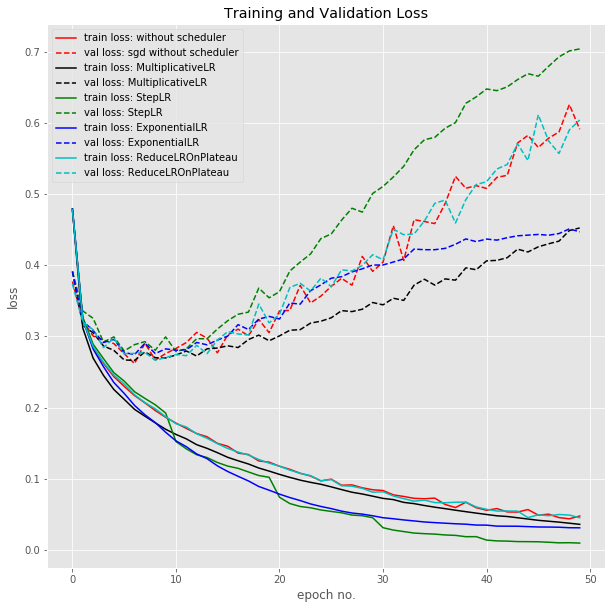

In [18]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 10)
x = range(len(train_loss_sgd_momentum))

plt.figure


plt.plot(x, train_loss_sgd_momentum, 'r', label="train loss: without scheduler")
plt.plot(x, test_loss_sgd_momentum, '--r', label="val loss: sgd without scheduler")

plt.plot(x, train_loss_time_based, 'k', label="train loss: MultiplicativeLR")
plt.plot(x, test_loss_time_based, '--k', label="val loss: MultiplicativeLR")

plt.plot(x, train_loss_step_decay, 'g', label="train loss: StepLR")
plt.plot(x, test_loss_step_decay, '--g', label="val loss: StepLR")

plt.plot(x, train_loss_exp_decay, 'b', label="train loss: ExponentialLR")
plt.plot(x, test_loss_exp_decay, '--b', label="val loss: ExponentialLR")

plt.plot(x, train_loss_plateau, 'c', label="train loss: ReduceLROnPlateau")
plt.plot(x, test_loss_plateau, '--c', label="val loss: ReduceLROnPlateau")

plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

# <font style="color:blue">14. Accuracy Plot</font>

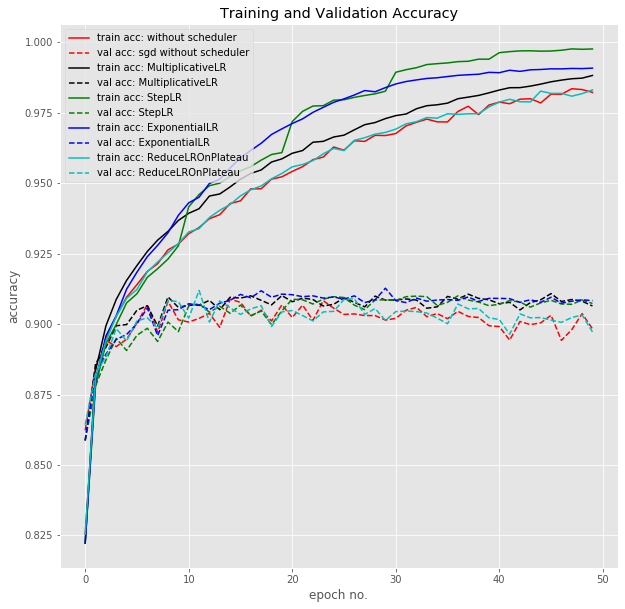

In [19]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 10)
x = range(len(train_loss_sgd_momentum))

plt.figure

plt.plot(x, train_acc_sgd_momentum, 'r', label="train acc: without scheduler")
plt.plot(x, test_acc_sgd_momentum, '--r', label="val acc: sgd without scheduler")

plt.plot(x, train_acc_time_based, 'k', label="train acc: MultiplicativeLR")
plt.plot(x, test_acc_time_based, '--k', label="val acc: MultiplicativeLR")

plt.plot(x, train_acc_step_decay, 'g', label="train acc: StepLR")
plt.plot(x, test_acc_step_decay, '--g', label="val acc: StepLR")

plt.plot(x, train_acc_exp_decay, 'b', label="train acc: ExponentialLR")
plt.plot(x, test_acc_exp_decay, '--b', label="val acc: ExponentialLR")

plt.plot(x, train_acc_plateau, 'c', label="train acc: ReduceLROnPlateau")
plt.plot(x, test_acc_plateau, '--c', label="val acc: ReduceLROnPlateau")

plt.xlabel('epoch no.')
plt.ylabel('accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')
plt.show()